# Getting started with RadIO

Welcome to the first notebook in series of tutorials covering deep learning research of lung cancer using RadIO. Here you will learn about (1) general approach of RadIO when working with dataset of scans and (2) perform basic preprocessing operations (load of data into memory and resize of scans). As you will see in a minute, the (1) will save you the trouble of looping through the dataset that cannot fit into memory. In turn, learning (2) will give you a good idea of how one can build complex preprocessing pipelines using RadIO.

In this tutorial you will work with [LUNA16 competition dataset](https://luna16.grand-challenge.org/), consisting of 888 cancer-annotated examples of scans of Computational Tomography (CT-scans). Annotations is simply a csv-table that contains location and diameter of cancerous nodules. In order to follow the tutorial, we advice you to download at least part of this dataset on [this link](https://luna16.grand-challenge.org/download/) (you will need a registration).

Alternatively, you can download a small set of scans along with cancer-annotations [here](some-dropbox-link). The archive takes no more than 500 MB and is just enough to get started with RadIO.

## 1. Working with dataset of scans with ease

The very first thing that one should understand about CT-scans is that they are **voluminous**. It is not possible to fit more than a few scans into memory. The only way to work with such large datasets is through an **indexing structure** (think of ...). In RadIO, you can create this structure in two lines of code:

In [1]:
import sys
sys.path.append('../')

In [7]:
LUNA_MASK = '/notebooks/data/MRT/luna/s*/*.mhd'      # set mask for scans from Luna-dataset here
from radio.dataset import FilesIndex
luna_index = FilesIndex(path=LUNA_MASK, no_ext=True) # ,no_ext=True) # preparing indexing structure

RadIO works with scans using *batch-classes* **`CTImagesBatch`** and **`CTImagesMaskedBatch`**, which describe the logic of processing batches of CT-scans (`load` of data from disk, `resize` of scans to different shape). When we combine data processing logic and the index, we obtain the `dataset`:

In [8]:
from radio.dataset import Dataset
from radio import CTImagesMaskedBatch
luna_dataset = Dataset(index=luna_index, batch_class=CTImagesMaskedBatch)

..and that's it, all necessary prerequisities are set up. It is time to get your hands on real data-processing operations of RadIO: `load` and `resize`.
##### Note
RadIO works with datasets using the **Dataset-framework.** Check [the link](https://github.com/analysiscenter/dataset) to find out more.

## 2. Preprocessing with RadIO

### 2.1 `Load` of data from disk

RadIO-team thinks of **preprocessing** as of chained sequence of operations, called `actions`. A sequence of actions is called `Pipeline`. Whichever preprocessing you want to do, you should start with setting up a pipeline in **lazy-mode**. That is, you only provide a **plan** of what will happen with data and no real computation is performed.

First and foremost, you need to load scans data from disk. Let us set up a short pipeline for this task.

In [26]:
from radio.dataset import Pipeline
preprocessing = Pipeline()                     # initialize empty Pipeline-object
preprocessing = preprocessing.load(fmt='raw')  # the thing is lazy. No calculation is performed here!

What we did was to assemble a `Pipeline` with one action `load` with arguments `fmt="raw"`. Argument `fmt` specifies the format of data and `raw` stands for **MetaImage-format** which is used for Luna-dataset.

Real calculation starts only when we pass a dataset through a pipeline. E.g., you can generate a batch of 3 scans with loaded data with this line of code:

In [33]:
batch = (luna_dataset >> preprocessing).next_batch(batch_size=3, shuffle=False)  # execution starts when you call next_batch

With the line above, you generated an empty batch, containing 3 scans-indices, and passed it through the sequence of actions. In this specific case, there was only one action in the sequence.

![title](imgs/flow.png)

Let us plot an axial slice of a scan from batch and make sure that the data was loaded:

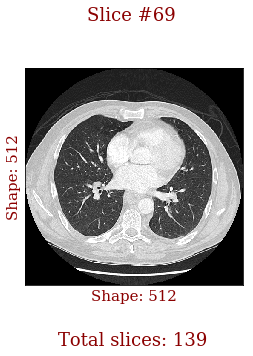

In [34]:
from utils import show_slice
show_slice(batch, scan_index=0, n_slice=69)

### 2.2 `Resize`: changing shape of scans-data using interpolation

As we can see, the loaded scan has shape **[139, 512, 512]** (**139** slices of shape **[512, 512]**). Clearly, the scan of such shape can eat **a lot** of GPU-memory. This can be a problem, if our goal is to build complex deep learning algorithms. Naturally, you may want to **resize** scans to a lesser shape without loosing much information. For this purpose you only need to add action `resize` to your preprocessing pipeline: 

In [35]:
preprocessing = preprocessing.resize(shape=(92, 256, 256)) # remember, nothing is executed here

Alternatively, you can build preprocessing pipeline from scratch, chaining all actions you need. RadIO-team advises to follow this approach. In that way, you can easily see all operations included in the workflow:

In [36]:
preprocessing = (Pipeline()                     # Initialize empty pipeline 
                 .load(fmt='raw')               # load data from disk
                 .resize(shape=(92, 256, 256))) # resize to shape (92, 256, 256)

You can now pass a batch of 3 scans through the preprocessing workflow (which now contains two actions: `load` and `resize`):

In [37]:
batch = (luna_dataset >> preprocessing).next_batch(batch_size=3, shuffle=False)

..and see the result for yourself:

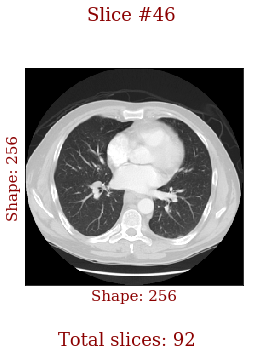

In [38]:
show_slice(batch, scan_index=0, n_slice=46)

As you can see, the scan now has different shape. In the same time, the content is roughly the same. Of course, `load` and `resize` are not the only actions implemented in RadIO. RadIO also includes actions
* `unify_spacing` (reshape scans so that spacings between different scans be the same: say, **[1.0, 1.0, 1.0]** mms).
* `dump` (preprocessed scans-data on disk for future use).
* `rotate` (the scans about z-axis for dataset-augmentation).
* `sample_nodules` (for cropping out small, cancerous and noncancerous, parts of scans for more efficient use of scans-dataset).

..and many more

Go [here](link-on-preprocessing-page) to see the full list.

## 3. What's next?

After reading this tutorial you should be able to
* Build a `Dataset` of computational tomogrpahy-scans from Luna-dataset, where `Dataset` is a structure, that indexes a large dataset on disk.
* Build simple preprocessing pipelines, that contain `load` of data from disk and `resize` of scans to different shape.
* Pass batches through pipelines using `next_batch`, thus changing the content of batches.

In the [next tutorial](link-on-next) you can dive deeper into preprocessing-capabilities of RadIO and build a full-fleged preprocessing workflow that ends with training a neural network [VNet](https://arxiv.org/abs/1606.04797) for segmentation cancerous tumors.